In [49]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchmetrics import F1Score
import matplotlib.pyplot as plt


Load and preprocess the training data

In [50]:
basal_train = np.load('basal_train.npy')
pre_seizure_train = np.load('pre_seizure_train.npy')

print(basal_train.shape)
print(pre_seizure_train.shape)

# Reshape basal_train to 2x72000 matrix
basal_train_reshaped = basal_train.reshape((basal_train.shape[1], -1))
pre_seizure_train_reshaped = pre_seizure_train.reshape((pre_seizure_train.shape[1], -1))
# Check the shape of basal_train_reshaped
print(basal_train_reshaped.shape)
print(pre_seizure_train_reshaped.shape)

(3, 2, 240000)
(3, 2, 60000)
(2, 720000)
(2, 180000)


Slice data into 2s segments

In [51]:
def create_windows_per_recording(data, window_size, label):
    windows = []
    labels = []

    num_windows = (data.shape[1] - window_size) // window_size + 1
    for i in range(num_windows):
        window = data[:, i * window_size : i * window_size + window_size]
        windows.append(window)
        labels.append(label)

    return np.array(windows), np.array(labels)



Set parameters and split train-test data

In [52]:
# Parameters
window_size = 2000  # equivalent to two seconds of data

# Create windows
basal_windows, basal_labels = create_windows_per_recording(basal_train_reshaped, window_size, 0)
pre_seizure_windows, pre_seizure_labels = create_windows_per_recording(pre_seizure_train_reshaped, window_size, 1)

# Concatenate the training data and their labels
X_train = np.concatenate([basal_windows, pre_seizure_windows])
y_train = np.concatenate([basal_labels, pre_seizure_labels])

# Split into validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Prepare the training data for the LSTM model

In [82]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device) 

        # Initialize cell state
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

model = LSTM(input_dim=2000, hidden_dim=100, output_dim=1, n_layers=10)

Split the data into training and validation sets

In [83]:
# Convert to PyTorch tensors
tensor_x_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train).reshape(-1, 1)
tensor_x_val = torch.Tensor(X_val) 
tensor_y_val = torch.Tensor(y_val).reshape(-1, 1)

# Create Tensor datasets
train_data = TensorDataset(tensor_x_train, tensor_y_train)
val_data = TensorDataset(tensor_x_val, tensor_y_val)

# dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [60]:
train_iter = iter(train_loader)
try:
    data, label = next(train_iter)
except StopIteration:
    print("The train_loader is empty.")

Create and train the LSTM model

In [84]:
# Loss and optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

# Get the training and validation losses and F1 scores
train_losses = []
val_losses = []
val_f1_scores = []

# Training loop
f1 = F1Score(task="binary").to(device)

for epoch in range(1000):
    loss = None
    val_loss = None
    val_f1 = None

    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_f1 = f1(torch.sigmoid(outputs).round(), labels)
            
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_f1_scores.append(val_f1.item())

    if loss is not None and val_loss is not None and val_f1 is not None:
        print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val F1 Score: {val_f1.item()}')
    else:
        print('No data in the DataLoader')


Epoch 1/10, Loss: 0.6554644703865051, Val Loss: 0.6408157348632812, Val F1 Score: 0.0
Epoch 2/10, Loss: 0.5788461565971375, Val Loss: 0.5971333384513855, Val F1 Score: 0.0
Epoch 3/10, Loss: 0.5053536891937256, Val Loss: 0.5938555598258972, Val F1 Score: 0.0
Epoch 4/10, Loss: 0.6288670301437378, Val Loss: 0.661353349685669, Val F1 Score: 0.0
Epoch 5/10, Loss: 0.493743360042572, Val Loss: 0.44232532382011414, Val F1 Score: 0.0
Epoch 6/10, Loss: 0.5406144857406616, Val Loss: 0.514609694480896, Val F1 Score: 0.0
Epoch 7/10, Loss: 0.29536402225494385, Val Loss: 0.7055560946464539, Val F1 Score: 0.0
Epoch 8/10, Loss: 0.24140037596225739, Val Loss: 0.812555730342865, Val F1 Score: 0.0
Epoch 9/10, Loss: 0.24112071096897125, Val Loss: 0.8753586411476135, Val F1 Score: 0.0
Epoch 10/10, Loss: 0.19800308346748352, Val Loss: 0.9626644849777222, Val F1 Score: 0.0
Epoch 11/10, Loss: 0.13667818903923035, Val Loss: 0.7696560025215149, Val F1 Score: 0.0
Epoch 12/10, Loss: 0.14921090006828308, Val Loss: 

Plot the training and validation performance

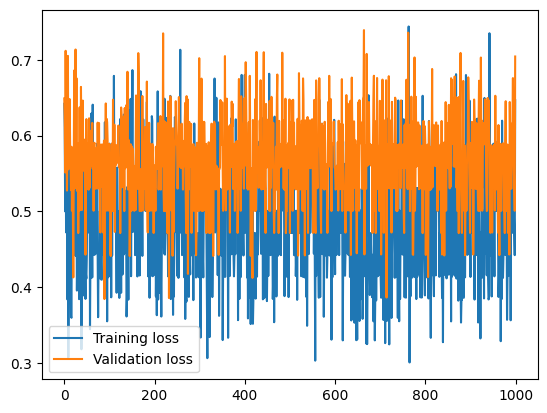

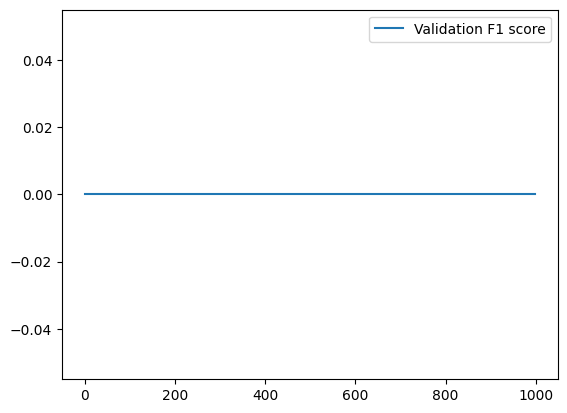

In [78]:
# Plot the results
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(val_f1_scores, label='Validation F1 score')
plt.legend()
plt.show()

Evaluate the model

In [30]:
# Load the test set
test_set = np.load('test_set.npy')

# Convert to tensor and create DataLoader
tensor_x_test = torch.Tensor(test_set)
test_data = TensorDataset(tensor_x_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get model predictions
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0].to(device))
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert to numpy array
        binary_predictions = (probabilities > 0.5).astype(int)  # Apply threshold
        predictions.extend(binary_predictions)

# Convert binary predictions to scalar values (0 or 1)
predictions = [pred.item() for pred in predictions]

# Create submission file
with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
